In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from jupyter_plotly_dash import JupyterDash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import numpy as np
import os
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
from sys import exc_info
from caiman import movie as cmovie

In [2]:
%load_ext autoreload
%autoreload 1
%aimport Regions, physio_def_1, numeric, Automatic

from physio_def_1 import *
from Regions import Regions
from numeric import *
from Automatic import *

In [3]:
os.chdir(os.path.expanduser("~"))

In [4]:
exampleNpzFile = "local_data/testdir/Experiment38a_7_Series016.npz"
# exampleNpzFile = "local_data/Sandra/2019_10_16/Experiment39a/Experiment39a_13_Series024.npz"
# exampleNpzFile = "local_data/Sandra/2019_10_16/Experiment39a/Experiment39a_8_Series019.npz"

In [5]:
outputStyle = {
    "color":"blue",
    "font-family":"Courier New",
    "font-size":"80%",
    "max-width": "700px",
    }
infoStyle = {
    "font-size":"70%",
    "font-family":"Arial",
    # "background-color":"lightcyan",
    "color":"grey",
    "max-width": "700px",
    }
bodyStyle = {
    "font-family":"Arial",
    "max-width": "700px",
    }

In [21]:
## global vars
npzFile = None
metadata = None
movie = None
regions = None
test = True

In [169]:
app = JupyterDash(__name__,
                  width=800,
#                   height=400,
                 )

APP_LAYOUT = [
    
    html.H1(children='CaRec Viewer',style=bodyStyle),
    html.Div("Please, think of a better name and let me know.",style=infoStyle),
    html.Br(),
    ####################################
#     html.H2(children='Importing',style=bodyStyle),
    html.Div('Enter path to an npz file, choose whether to check for movement, and press enter.',style={**bodyStyle, "display":"inline-box"}),
    html.Div([
        dcc.Checklist(id="check_movement_choice",options=[{"label":'Check for movement',"value":"yes"}],value=[],
                          style={**infoStyle, "display":"inline-box","float":"right"}),
    ],style={"width":"200px"}),
    
    dcc.Input(id="npz_filename",
            type="text",
            placeholder=exampleNpzFile,
            debounce=True,
            size = 100,
            value=exampleNpzFile if test else "",
        ),

#     html.Div('Loading can take a few seconds [for very large files even a minute].',style={**infoStyle,"text-align": "center"}),
    html.Br(),
    
    html.Div(id="npz_feedback", children="",style=outputStyle),#To start, enter the full path to a file and press enter. Note, that loading can take a few seconds [for very large files even a minute].

    html.Div(children=[html.Br(),"    Spatial filtering**"],style={**bodyStyle,'display': 'inline-block'}),

    dcc.Input(id="gSig_filt_input",
        type="text",
        debounce=True,
        size = 5,
        value="",
        placeholder="3",
        style={'display': 'inline-block'}),    

    html.Div(html.Abbr(
        children="[hover mouse for more info]",
        title="""For the proper analysis, you need to set the size of the spatial filter. Its value should be of the order of the  half of the typical cell dimension (in pixels!). """#In many of our recording, pixel size is around 2 µm. If we consider a typical cell of 10 µm, filter should be around 10/2/2 = 2.5. It needs to be an integer, so reasonable numbers to put would be 2 or 3, perhaps even 4. You can change it later.
        ),style={**infoStyle,'display': 'inline-block'}),

    html.Div(id="roi_feedback", children="",style=outputStyle),
    
    dcc.Graph(id='images',figure=baseFig,),

    html.Div(children="Resample*",style={'display': 'inline-block'}),
    
    dcc.Input(id="resample_input",
        type="text",
        debounce=True,
        size = 5,
        placeholder="5",
        value="",
        style={'display': 'inline-block'}),
    
    html.Div(children=" ",style={"width":"20px",'display': 'inline-block'}),
    html.Div(children=" ", id="resample_feedback",
             style={'display': 'inline-block',**outputStyle}),
    
    html.Div(style=infoStyle,
        children=[
        """
        *Resampling is optional (and irreversible). It is only useful to speed up the analysis downstream.
        Enter the new desired frequency in Hz (e.g. 5), and press enter.
        """,
        html.Br(),],),
    
    html.H3(children='ROIs', style=bodyStyle),
    html.Div("Please, choose which ROIs you'd want to see.", style=bodyStyle),
    html.Br(),
    html.Div("First, toggle some basic filtering. Then, you can use the lasso (or box) tool in the left graph to select ROIs you want to see the trace of. Use shift to select multiple regions.",style=infoStyle),
    html.Br(),
    html.Div([
        dcc.RadioItems(id="roi_choice",
            options=[
                {'label': 'Largest', 'value': 'largest'},
                {'label': 'Random', 'value': 'rnd'},
                {'label': 'Interesting', 'value': 'interest'},
                {'label': 'Central', 'value': 'central'},
                {'label': 'Outer', 'value': 'outer'},
            ],
         value='interest'),
        html.Div("How many?", style={**bodyStyle,"display":"inline-block"}),
        dcc.Input(id="roi_choice_number",
                type="text",
                debounce=True,
                size = 10,
                value='3' if test else "20"
            )
    ],style={"display":"inline-block","width":"49%"}),
#     html.Br(),
    html.Div([
        "Show downsampled to",
        dcc.Input(id="show_freq_input",
            type="text",
            debounce=False,
            size = 3,
            value='1'),
        "Hz"
        ], style={**bodyStyle,"display":"inline-block", "width":"49%"}, ),
    html.Br(),
    html.Div(dcc.Graph(id='show_rois',      figure=baseFig), style={"display":"inline-block"}),
    html.Div(dcc.Graph(id='show_raw_traces',figure=baseFig), style={"display":"inline-block"}),
    html.Div([
       "Trace ROIs:",
        dcc.Input(id="selected-indices",
            type="text",
            debounce=False,
            size=60,
            value="",
         ), 
    ],style={**bodyStyle,"display":"inline-box"}),
    
    html.Div([
       "hover ROI:",
        html.Pre(
            id='hover-data',
            style={
                'border': 'thin lightgrey solid',
                'overflowX': 'scroll',
                'overflowY': 'scroll',
                "height": "100px",
                "width": "200px",
                }
        ),
    ],style={**bodyStyle,"display":"inline-box"}),
    
    html.Div([
        "Selected Data:",
        html.Pre(id='selected-data',
                 style={
            'border': 'thin lightgrey solid',
            'overflowX': 'scroll',
            'overflowY': 'scroll',
            "height": "100px",
            "width": "200px",
            }),
        ],style={**bodyStyle,"display":"inline-box"}),
    html.Div(
        id="shown_rois",
        children="", style={**outputStyle,
                            "width":"100px",
                            "height": "30px",
                            'overflowX': 'scroll',
                            'overflowY': 'scroll',},),
    html.Div(
        id="spare_out",
        children="",
        style={**outputStyle,"width":"100px"}
    ),

    ]

if test: test=False

In [170]:
@app.callback(
    Output("resample_feedback", "children"),
    [Input("resample_input", "value")]
             )
def resample_callback(val):
    try:
        from Automatic import resample
        if val == "":
            feedback = ""
        else:
            global movie
            movie = resample(movie,newFreq)
            feedback = f"Resampling finished. New frequency is {movie.fr:.4} Hz."
            regions.update(movie)
        return feedback
    except:
        return "ERROR: "+exc_info().__repr__()
    

In [171]:
@app.callback([Output("npz_feedback", "children"),
               Output("gSig_filt_input", "value")],
              [Input("npz_filename", "value")],
              [State("check_movement_choice","value")])
def loadMovie(val,mv):
    if str(val)=="":
        return ('Loading can take a some time [for very large files even minutes].',"")
    try:
        from pandas import read_csv
        global npzFile, movie, metadata, cell_halfwidth_in_px, regions
        npzFile = val
        movie = import_npz_files([npzFile])
        movie = movie.astype("float")
        if len(movie.shape)==2:        
            movie = movie.reshape((1,-1))
        movie = cmovie(movie)
        timeframes = len(movie)
        feedback = [
            f"{npzFile} loaded successfully.",
            html.Br(),
            f"The recording consists of {timeframes} frame(s)."
        ]
        feedback += [ ]
        try:
            metadata = read_csv(npzFile.replace("npz","txt")).loc[0]
            if not hasattr(metadata,"freq"):
                metadata.freq = 1
            movie.fr = metadata.freq
            timeframes = metadata['T']
            assert timeframes==len(movie)
            freq = metadata.freq
            pxsize = metadata.pxSize
            feedback += [
                f"Info from metadata: frequency {freq:.4} Hz, and pixel size {pxsize:.3} µm.",
            html.Br(),
            ]
        except:
            pxsize = 1
            freq = 1
            feedback += [
                f"WARNING: Missing medatada. Assuming the frequency of {freq:.4} Hz, and pixel size of {pxsize:.3} µm. I strongly suggest you set the spatial filter carefully.",
            html.Br(),
            ]
        cell_halfwidth_in_px = int(np.ceil(6./pxsize))
        feedback += [
            f"Automatic size of the spatial filter based on pizel size: {cell_halfwidth_in_px} [you can change it below]",
            html.Br(),]
        
        # resample temporarily to lower frequency, to initiate ROIs and check for motion correction
        if freq>3:
            
            freqMC = 3
            n_rebin = int(movie.fr/freqMC)

            rebinned_movie = rebin(movie,n_rebin).astype("float32")
            rebinned_movie = cmovie(rebinned_movie)
            rebinned_movie.fr = movie.fr/n_rebin
        else:
            rebinned_movie = movie.astype("float32")
            feedback += [
                "(This is probably a lot higher frequency than you need, consider resampling to lower frequency, e.g. 5 Hz.)",
                html.Br(),
                        ]
        if len(mv):
            rigidShifts = getRigidShifts(rebinned_movie, (cell_halfwidth_in_px,)*2)
            maxshift = np.abs(rigidShifts).max()
            if maxshift>cell_halfwidth_in_px/5:
                feedback += [
                    f"It seems there is also some movement in the recording, at least {maxshift}px. You may want to first correct for that.",
                    html.Br(),
                ]
                
        # initiate ROIs
        regions = createRegions(rebinned_movie, cell_halfwidth_in_px, mode="diff_std")
        del regions.statImages["diff_mean"]

        regions.update(movie)

        return (feedback, str(cell_halfwidth_in_px))
    except:
        return ([html.P("ERROR: "+exc_info().__repr__())],"None")

In [172]:
@app.callback(
    [Output("roi_feedback", "children"), Output("images", "figure"), Output("roi_choice","value")],
    [Input("gSig_filt_input", "value")])
def recalcRois(val):
    if val == "":
        return ("",baseFig,"")
    try:
        global movie,regions
        x = int(val)
        if regions.filterSize != x:
            regions = createRegions(movie, x)
            # merge obvious ROIs
            from Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph
            while True:
                peak2bnd = getPeak2BoundaryDF(regions.df)
                df = peak2bnd.query("dist<1.")[["i","j"]]
                if len(df)==0: break
                gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
                # plotRoi_to_be_connected(gRois,regions)
                dropped = mergeBasedOnGraph(gRois,regions)
                if dropped == 0: break

            regions.purge_lones((cell_halfwidth_in_px*.5)**2)
            feedback = [f"Size of the spatial filter changed to {x}.",html.Br()]
        else:
            feedback = [""]
        feedback += [f" Number of detected ROIs: {len(regions.df)}"]
        return (feedback, plotStatsFig(regions),"interest")
    except:
        return ("ERROR from recalcRois: "+exc_info().__repr__(),go.Figure(),"")

In [173]:
@app.callback(
    [Output("shown_rois", "children"),
     Output("show_rois", "figure"),
    ],
    [Input("roi_choice", "value")],
    [State("roi_choice_number", "value")],)
def parseRoiChoices_callback(roi_mode,roi_number):
    try:
        if roi_mode=="":
            return "", baseFig
        else:
            global regions
            ix = parseRoiChoices(regions, roi_mode,roi_number)
            feedback = ", ".join(ix.astype(str))
            trfig = showRoisOnly(regions,indices=ix, im=regions.statImages["diff_std"])
            trfig.update_layout({
                "height":360,
                "width":320,
                "margin":dict(l=10, r=10, t=50, b=50),
                "paper_bgcolor":"white",
            })
            return feedback,trfig
    except:
        return ("ERROR from parseRoiChoices_callback: "+exc_info().__repr__(), baseFig)

In [174]:
@app.callback(
    [Output('selected-data', 'children'),
     Output('selected-indices', 'value')],
    [Input('show_rois', 'selectedData'),
     Input("roi_choice", "value")],
    [State("roi_choice_number", "value"),]
)
def display_selected_data(selectedData,roi_mode,roi_number):
    try:
        if selectedData is None:
            selectedData = {"points":[]}
        import json
        chosen = np.unique([p["hovertext"] for p in selectedData["points"]])
        if len(chosen) ==0:
            chosen = parseRoiChoices(regions, roi_mode,roi_number).astype(str)
        return json.dumps(selectedData, indent=2) , ", ".join(chosen)
    except:
        return "ERROR from display_selected_data: "+exc_info().__repr__() , ""

In [175]:
# @app.callback(
#     Output('hover-data', 'children'),
#     [Input('show_rois', 'hoverData'),]
# )
# def display_hover_data(hoverData):
#     try:
#         if hoverData is None:
#             hoverData = {"points":[]}
#         import json
#         chosen = np.unique([p["hovertext"] for p in hoverData["points"]])
#         return json.dumps(hoverData, indent=2)
#     except:
#         return "ERROR from display_hover_data: "+exc_info().__repr__() 

In [176]:
@app.callback(
     [Output("show_raw_traces", "figure"),Output("spare_out", "children")],
    [Input("show_rois", "hoverData")],
    [State("show_freq_input", "value")])
def plotHovered(hoverData, showFreq):
    try:
        global regions
        if not hasattr(regions,"time"):
            regions.calcTraces(movie)
        showFreq = float(showFreq)
        n_Avg = int(regions.movie.fr/showFreq)
        
        try:
            ix = [int(hoverData["points"][0]["hovertext"])]
            trfig = plotRawTraces(regions,indices=ix,nAvg=n_Avg)

            
            trfig.update_layout({
#                 "height":360,
#                 "width":320,
#                 "margin":dict(l=10, r=10, t=50, b=50),
                "paper_bgcolor":"white",
            })
            return trfig,"ok"
        except:
            return baseFig,"nothing yet"
    except:
        return baseFig, "ERROR from plotHovered: "+exc_info().__repr__() 

In [177]:
# @app.callback(
#      [Output("show_raw_traces", "figure"),Output("spare_out", "children")],
#     [Input("selected-indices", "value")],
#     [State("show_freq_input", "value"),
#     ],)
# def plotRawTraces_callback(chosen, showFreq):
#     try:
#         global regions
#         if not hasattr(regions,"time"):
#             regions.calcTraces(movie)
#         showFreq = float(showFreq)
#         n_Avg = int(regions.movie.fr/showFreq)
#         try:
#             ix = np.array(chosen.strip(" ,").split(","))
#             ix = ix.astype(int)
#             trfig = plotRawTraces(regions,indices=ix,nAvg=n_Avg)
# #             trfig.update_layout({"width":200})
#             return trfig,"ok"
#         except:
#             return baseFig,"nothing yet"
#     except:
#         return baseFig, "ERROR: "+exc_info().__repr__() 

In [178]:
app.layout = html.Div(children=APP_LAYOUT)
app._repr_html_() 
link2app = "https://ctn.physiologie.meduniwien.ac.at"+app.get_app_root_url()
HTML(f'click to start: <a href="{link2app}">{link2app}</a>')

In [114]:
# app.layout = html.Div(children=APP_LAYOUT)
# app

In [19]:
# plotStatsFig(regions)

In [150]:
rr = createRegions(movie[:,:10,:20],cell_halfwidth_in_px)

Initialized with 9 rois.
Dropped 1 as too weak. Left with 8.


In [168]:
# showRoisOnly(rr, im=rr.statImages["mean"])

In [154]:
rr.image.shape

(10, 20)

In [146]:
rr.df["boundary"]

0    [(-0.5, 2.5), (0.5, 2.5), (1.5, 2.5), (1.5, 3....
Name: boundary, dtype: object

In [30]:
from Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, plotRoi_to_be_connected, mergeBasedOnGraph

In [40]:
peak2bnd = getPeak2BoundaryDF(regions.df)

In [42]:
df = peak2bnd.query("dist<1.")[["i","j"]]
len(df)

0

In [35]:
#         if len(df)==0: break

In [36]:
gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)

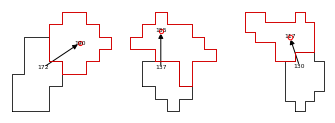

In [37]:
plotRoi_to_be_connected(gRois,regions)

In [38]:
dropped = mergeBasedOnGraph(gRois,regions)

3 subsumed into existing ROIs.


In [39]:
dropped

3

In [ ]:
        if dropped == 0: break

In [65]:
import pandas as pd

In [66]:
NNstats = pd.DataFrame(columns=["i","j"])
C = regions.df
for i in C.index:
    for j in C.neighbors[i]:
        larger = C.loc[j,"peakValue"]
        smaller = C.loc[i,"peakValue"]
        if smaller>larger: continue
        pks = np.vstack(C.loc[[i,j],"peak"])
        means  = np.array([np.mean(px,axis=0) for px in C.loc[[i,j],"pixels"]])
        dmeans = np.sum(np.diff(means)**2)**.5
        dpks   = np.sum(np.diff(pks)**2)**.5
        NNstats = NNstats.append({k:eval(k) for k in ["i","j","dmeans","dpks"]},ignore_index=True)

NNstats["i"] = NNstats["i"].astype(int)
NNstats["j"] = NNstats["j"].astype(int)
NNstats.sort_values(["i","dpks"], inplace=True)
NNstats["pk2mn"] = NNstats["dpks"]/NNstats["dmeans"]

In [67]:
ii = NNstats.query("pk2mn<.5").index

In [70]:
import networkx as nx

1 subsumed into existing ROIs.


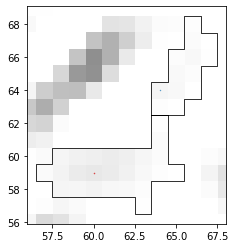

In [71]:
ii = NNstats.query("pk2mn<.5").index
if len(ii):
    gRois = nx.DiGraph()
    for i in ii:
        gRois.add_edge(*NNstats.loc[i,["i","j"]].astype(int))
    ixs = np.unique( NNstats.loc[ii,["i","j"]].values)
    ax = plt.subplot(111)
    regions.plotEdges(ix = ixs, image=False,ax=ax)
    xl = plt.xlim()
    yl = plt.ylim()
    regions.plotPeaks(ix = ixs, image=True,ms=.1,ax=ax,
                      imkw_args={"cmap":"Greys","vmin":0}
                     )
    plt.ylim(yl)
    plt.xlim(xl)

    mergeBasedOnGraph(gRois.to_directed(),regions)

In [91]:
ii = C.query(f"size<{(cell_halfwidth_in_px*.8)**2} and Nneighbors==0").index

In [92]:
C.drop(index=ii,inplace=True)

In [93]:
regions.update()


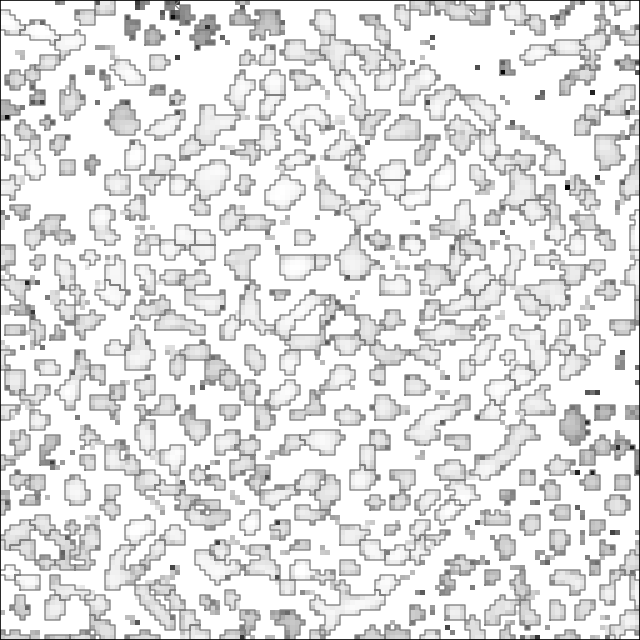

In [88]:
showRoisOnly(regions, indices=ii,showall=True,)

(array([ 0.,  0.,  0.,  0., 17., 12., 14., 19., 21., 23., 20., 24., 21.,
        17., 15., 17., 20.,  7.,  9., 15., 13., 11.,  5., 10.,  4.,  4.,
         5.,  4.,  2.,  3.,  5.,  3.,  0.,  3.,  3.,  3.,  3.,  3.,  1.,
         1.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 6

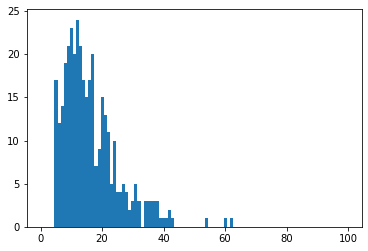

In [73]:
plt.hist(C["size"],np.arange(100)+.5)

In [72]:
regions.pru

0      2
1      1
2      3
3      1
4      0
      ..
359    0
360    1
361    1
362    0
363    0
Name: Nneighbors, Length: 364, dtype: int64

In [120]:
# def showRoisOnly(regions, indices=None, im=None, showall=True):
#     if indices is None:
#         indices = regions.df.sort_values("size",ascending=False).index[:10]
#     f = go.Figure()
#     for i in indices:
#         cl = MYCOLORS[i%len(MYCOLORS)]

#         bds = regions.df.loc[i,"boundary"]
#         bds += [bds[0]]
#         y,x = np.array(bds).T
#         ypts,xpts = np.array(regions.df.pixels[i]).T
#         ln = go.Scatter(x=x,y=y,
#                         line=dict(width=1,color=cl),
#                         mode="lines",
#                         showlegend = False,
#                         name = str(i),
#                         hoveron='points+fills',
#                         hoverinfo='text',
#                         hovertext=["%i"%(i)]*len(bds),
                        
#                         fill="toself",
#                         opacity = .2,
#                      )
#         f.add_trace(ln)
#     if im!="none":
#         # f.add_heatmap(z=im, hoverinfo='skip',showscale=False,colorscale=plxcolors.sequential.Greys)
#         imgpointer = createStaticImage(im,regions,showall=showall)

#         f.add_layout_image(
#             dict(
#                 source=imgpointer,
#                 xref="x",
#                 yref="y",
#                 x=-.5,
#                 y=regions.image.shape[1]-.5,
#                 sizex=regions.image.shape[1],
#                 sizey=regions.image.shape[0],
#                 sizing="stretch",
#                 opacity=1,
#                 layer="below")
#             )
    
#     f.update_layout({
#         "height":360,
#         "width":320,
#         "margin":dict(l=10, r=10, t=50, b=10),
#     #     "paper_bgcolor":"grey",
#         "xaxis": {
#             "linecolor": 'black',
#             "linewidth": 1,
#             "mirror": True,
#             "tickvals": [],
#             "range":[-.5,regions.image.shape[1]-.5]
#         },
#         "yaxis": {
#             "linecolor": 'black',
#             "linewidth": 1,
#             "mirror": True,
#             "tickvals": [],
#             "range":[-.5,regions.image.shape[0]-.5]
#         },
#         'clickmode': 'event+select'
#     })
        
#     return f

In [121]:
# showRoisOnly1(regions,indices=range(len(regions.df)))

In [34]:
exampleNpzFile

'local_data/testdir/Experiment38a_7_Series016.npz'